# Bernoulli Naive Bayes

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [69]:
import pandas as pd
import numpy as np
from collections import defaultdict

class bernoulli_naive_bayes:
    
    def __init__(self, smoothing = 1.):
        """
        Bernoulli Naive Bayes builds it's understanding of the data by
        applying Bayes rule and calculating the conditional probability of
        being a class based on a probabilistic understanding of how the 
        class has behaved before. We only care if a feature is zero or non-zero
        in this style of naive bayes and will calculate our conditional probabilities
        accordingly. 
        ---
        Inputs:
        smoothing: the Laplace smoothing factor overcome the problem of multiplying
        a 0 probability, that causes the total probability to be 0.
        """
        self._prob_by_class = defaultdict(float)
        self._cond_probs = defaultdict(lambda: defaultdict(float))
        self._log_prob_by_class = defaultdict(float)
        self._log_cond_probs = defaultdict(lambda: defaultdict(float))
        self._data_cols = None
        self._smoothing = smoothing
    
    def fit(self, X, y):
        """
        For each class, we find out what percentage of the data is that class.
        We then filter the data so only the rows that are that class remain,
        and then go column by column - calculating what percentage of rows are
        non-zero, given the class. We store all of these values to be used later 
        for predictions. We also store the log of these values for later prediction.
        ---
        Input: X, data (array/DataFrame)
        y, targets (array/Series)
        """
        X = self.convert_to_array(X)
        y = self.pandas_to_numpy(y)
        self._data_cols = X.shape[1]
       
        self._classes = np.unique(y)
        
        for cl in self._classes:
            filtered_targets = y[y == cl]
            filtered_data = X[y == cl]
            self._prob_by_class[cl] = len(filtered_targets)/len(y)
            self._log_prob_by_class[cl] = np.log(self._prob_by_class[cl])
            denom = len(filtered_targets)
            for col in range(self._data_cols):
                binarized_column = filtered_data.T[col] > 0 
                num_ones = np.sum(binarized_column)
                #smoothing applied here so we never get a zero probability
                self._cond_probs[cl][col] = (num_ones+self._smoothing)/(denom+self._smoothing) 
                self._log_cond_probs[cl][col] = np.log(self._cond_probs[cl][col])
                
    def predict(self, X):
        """
        Wrapper to return only the class of the prediction
        ---
        Input: X, data (array/dataframe)
        """
        return self._predict(X, mode="predict")
    
    def predict_proba(self, X):
        """
        Wrapper to return probability of each class of the prediction
        ---
        Input: X, data (array/dataframe)
        """
        return self._predict(X, mode="predict_proba")
    
    def predict_log_proba(self, X):
        """
        Wrapper to return log of the probability of each class of 
        the prediction.
        ---
        Input: X, data (array/dataframe)
        """
        return self._predict(X, mode="predict_log_proba")
    
    def _predict(self, X, mode="predict"):
        """
        For each data point, we go through and calculate the probability
        of it being each class. We do so by using the probability of
        seeing each value per feature, then combining them together with 
        the class probability. We work in the log space to fight against
        combining too many really small or large values and under/over 
        flowing Python's memory capabilities for a float. Depending on the mode
        we return either the prediction, the probabilities for each class,
        or the log of the probabilities for each class.
        ---
        Inputs: X, data (array/DataFrame)
        mode: type of prediction to return, defaults to single prediction mode
        """
        X = self.convert_to_array(X)
        X = (X > 0).astype(int) # convert to 1 or 0
        results = []
        for row in X:
            beliefs = []
            for cl in self._classes:
                prob_for_class = self._log_prob_by_class[cl]
                for col in range(self._data_cols):
                    p = self._log_cond_probs[cl][col]
                    # The row or (1-row) chooses either the 0 or 1 probability
                    # based on whether our row is a 0 or 1.
                    prob_for_class += p*row[col] + (1-p)*(1-row[col])
                beliefs.append([cl, prob_for_class])
            
            if mode == "predict_log_proba":
                _, log_probs = zip(*beliefs)
                results.append(log_probs)
            
            elif mode == "predict_proba":
                _, probs = zip(*beliefs)
                unlog_probs = np.exp(probs)
                normed_probs = unlog_probs/np.sum(unlog_probs)
                results.append(normed_probs)
            
            else:
                sort_beliefs = sorted(beliefs, key=lambda x: x[1], reverse=True)
                results.append(sort_beliefs[0][0])
        
        return np.array(results).reshape(-1,1)
    
    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: accuracy (float)
        """
        pred = self.predict(X)
        correct = 0
        for i,j in zip(y,pred):
            if i == j:
                correct+=1
        return float(correct)/float(len(y))
      
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

### Let's test it!

Let's generate some data to test with. We'll use the example of senators voting on 4 different issues (only 3 of which are relevant) and then trying to predict which party the senator is from.

In [70]:
def get_data():
    votes = [0,1]
    senators = np.random.choice(votes, replace=True, size=(100,4))
    df = pd.DataFrame(senators, columns=['vote1','vote2','vote3','vote4'])
    
    def calculate_party(row):
        x = row['vote1']
        y = row['vote2']
        z = row['vote3']

        party = 0.7*x + 0.5*y - z + np.random.normal(0,0.3)
        if party > 0.1:
            return 'Dem'
        elif party > 0.01:
            return 'Ind'
        else:
            return 'Rep'
    
    df['party'] = df.apply(calculate_party,axis=1)
    print(df.party.value_counts())
    return df.iloc[:,:-1],df.iloc[:,-1]
    

In [71]:
X, y = get_data()

Dem    50
Rep    43
Ind     7
Name: party, dtype: int64


In [72]:
nb = bernoulli_naive_bayes()
nb.fit(X.iloc[:90],y.iloc[:90])

Let's look at the probability of voting YES on each issue by what party the senators in our training data were.

In [73]:
nb._cond_probs

defaultdict(<function __main__.bernoulli_naive_bayes.__init__.<locals>.<lambda>>,
            {'Dem': defaultdict(float,
                         {0: 0.72340425531914898,
                          1: 0.68085106382978722,
                          2: 0.25531914893617019,
                          3: 0.55319148936170215}),
             'Ind': defaultdict(float,
                         {0: 0.5714285714285714,
                          1: 0.7142857142857143,
                          2: 0.7142857142857143,
                          3: 0.42857142857142855}),
             'Rep': defaultdict(float,
                         {0: 0.35897435897435898,
                          1: 0.30769230769230771,
                          2: 0.82051282051282048,
                          3: 0.5641025641025641})})

Now we can predict!

In [74]:
nb.predict(X.iloc[0:2])

array([['Dem'],
       ['Rep']], 
      dtype='<U3')

In [75]:
nb.predict_proba(X.iloc[0:2])

array([[ 0.77718662],
       [ 0.03728351],
       [ 0.18552987],
       [ 0.45198999],
       [ 0.01970065],
       [ 0.52830935]])

In [76]:
nb.predict_log_proba(X.iloc[0:2])

array([[ 2.04139699],
       [-0.99573227],
       [ 0.60893236],
       [ 3.81022039],
       [ 0.6772122 ],
       [ 3.96624235]])

We have an accuracy of 80%, which is the same as SkLearn's accuracy!

In [77]:
nb.score(X.iloc[90:],y.iloc[90:])

0.8

In [78]:
from sklearn.naive_bayes import BernoulliNB

nb_sk = BernoulliNB()
nb_sk.fit(X.iloc[:90],y.iloc[:90])
nb_sk.score(X.iloc[90:],y.iloc[90:])

0.80000000000000004

Let's visualize the vote probability by party - by looking at this we can see which YES votes tend to indicate Democrat, Independent, or Republican. Our model is just learning that - in this data sample at least - that Democrats are much more likely to vote yes on the first issue than Republicans. The same is true for Independents, but since they are such a small part of our sample, we aren't likely to guess Independent unless we're VERY sure.

In [79]:
probs = np.zeros((3,4))
for cl, d in nb._cond_probs.items():
    for val in d.items():
        if cl == 'Dem':
            i=0
        if cl == 'Ind':
            i=1
        if cl == 'Rep':
            i=2
        probs[i][val[0]] = val[1]

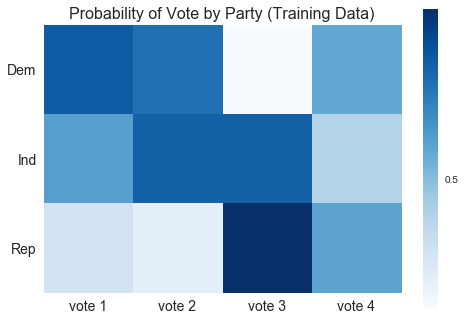

In [80]:
plt.style.use('seaborn')
fig_plot = plt.imshow(probs, cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.xticks()
ax = plt.gca()
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['vote 1','vote 2','vote 3','vote 4'], fontsize=14)
ax.set_yticks([0,1,2])
ax.set_yticklabels(['Dem','Ind','Rep'], fontsize=14);
fig = plt.gcf()
cbar = fig.colorbar(fig_plot, ticks=[0, 0.5, 1]);
plt.title("Probability of Vote by Party (Training Data)", fontsize=16);